In [2]:
# Origen y descripción de conjunto de datos:
# https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records

In [42]:
# Importar librerías
import pandas as pd
# Importar SVM, en scikit-learn se llama Support Vector Classifier (SVC)
from sklearn.svm import SVC
# Importar objeto para k-fold cross-validation con búsqueda aleatoria de hyperparámetros
from sklearn.model_selection import RandomizedSearchCV
# Importar objeto para separación de datos en conjuntos de entrenamiento y evaluación
from sklearn.model_selection import train_test_split
# Obtener valore de una distribución uniforme
from scipy.stats import uniform, expon
# Importar objeto para escalamiento de datos
from sklearn.preprocessing import StandardScaler
# Importar metricas de evaluación
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
# Importar objeto para imprimir matriz de confusión
from sklearn.metrics import confusion_matrix
# Importar objeto para imprimir reporte de clasificación 
from sklearn.metrics import classification_report
# Plots
import matplotlib.pyplot as plt
# Import object to plot Precision-Recall curve
from sklearn.metrics import PrecisionRecallDisplay
import numpy

In [4]:
# Leer datos en dataframe
data = pd.read_csv("../heart_failure_clinical_records_dataset.csv")
data.head(6)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1


In [5]:
# Verificar categorías de clase
data['DEATH_EVENT'].unique()

array([1, 0], dtype=int64)

In [6]:
# Verificar dimensionalidad de datos
data.shape

(299, 13)

In [7]:
# Verificar ejemplos por categoría
print(data.groupby('DEATH_EVENT').size())

DEATH_EVENT
0    203
1     96
dtype: int64


In [34]:
# Preparar datos
# X = sólo datos de características de ejemplos
# y = categorías de clase para cada ejemplo
X = data.iloc[:,[0,1,4,5,7,8]]  # all rows, all the features and no labels
y = data.iloc[:, 12]  # all rows, label only
print("Datos")
print(X.head())
print("Categorias de clase")
print(y.head())

Datos
    age  anaemia  ejection_fraction  high_blood_pressure  serum_creatinine  \
0  75.0        0                 20                    1               1.9   
1  55.0        0                 38                    0               1.1   
2  65.0        0                 20                    0               1.3   
3  50.0        1                 20                    0               1.9   
4  65.0        1                 20                    0               2.7   

   serum_sodium  
0           130  
1           136  
2           129  
3           137  
4           116  
Categorias de clase
0    1
1    1
2    1
3    1
4    1
Name: DEATH_EVENT, dtype: int64


In [35]:
# Escalamiento de datos
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
print("Datos")
print(X)

Datos
[[ 1.19294523 -0.87110478 -1.53055953  1.35927151  0.49005699 -1.50403612]
 [-0.49127928 -0.87110478 -0.00707675 -0.73568819 -0.28455235 -0.14197615]
 [ 0.35083298 -0.87110478 -1.53055953 -0.73568819 -0.09090002 -1.73104612]
 ...
 [-1.33339153 -0.87110478  1.85495776 -0.73568819 -0.57503085  0.31204384]
 [-1.33339153 -0.87110478 -0.00707675 -0.73568819  0.00592615  0.76606383]
 [-0.9123354  -0.87110478  0.58538877 -0.73568819  0.19957848 -0.14197615]]


In [36]:
# Separación de datos en conjuntos de entrenamiento y evaluación

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [37]:
# SVM

svm_model= SVC()

# The gamma parameter defines how far the influence of a single training example reaches, 
# with low values meaning ‘far’ and high values meaning ‘close’. 
# The gamma parameters can be seen as the inverse of the radius of influence of 
# samples selected by the model as support vectors.

# The C parameter trades off misclassification of training examples against 
# simplicity of the decision surface. 
# A low C makes the decision surface smooth, 
# while a high C aims at classifying all training examples correctly 
# by giving the model freedom to select more samples as support vectors.

search_parameters = {'C': expon(scale=100), 'gamma': expon(scale=.1),
  'kernel': ['rbf'], 'class_weight':['balanced', None]}

In [38]:
clf = RandomizedSearchCV(svm_model, search_parameters, random_state=0, cv=5, 
                                    scoring='f1_weighted', verbose=2, n_jobs=-1)
classifier = clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [39]:
# Verificamos resultados de entrenamiento y cross-validation
print("Mejor F-1 weighted score")
print(classifier.best_score_)
print("Mejores hyperparámetros")
print(classifier.best_params_)

Mejor F-1 weighted score
0.768193299186883
Mejores hyperparámetros
{'C': 5.838467078070334, 'class_weight': 'balanced', 'gamma': 0.048360210090225335, 'kernel': 'rbf'}


In [40]:
# Evaluación
y_pred= classifier.predict(X_test)
print("Resultados de evaluación")
print("F-1 weighted: {}".format(f1_score(y_test, y_pred, average='weighted')))
print("Precision: {}".format(precision_score(y_test, y_pred)))
print("Recall: {}".format(f1_score(y_test, y_pred)))
print("AUROC: {}".format(roc_auc_score(y_test, y_pred, average='weighted')))

Resultados de evaluación
F-1 weighted: 0.7488888888888889
Precision: 0.6818181818181818
Recall: 0.6666666666666666
AUROC: 0.7314923619271445


In [43]:
# Matriz de confusión
confusion_matrix=confusion_matrix(y_test,y_pred)
print(confusion_matrix)

[[30  7]
 [ 8 15]]


In [ ]:
# Reporte de clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79        37
           1       0.69      0.48      0.56        23

    accuracy                           0.72        60
   macro avg       0.71      0.67      0.68        60
weighted avg       0.71      0.72      0.70        60



Text(0.5, 0, 'False Positive Rate')

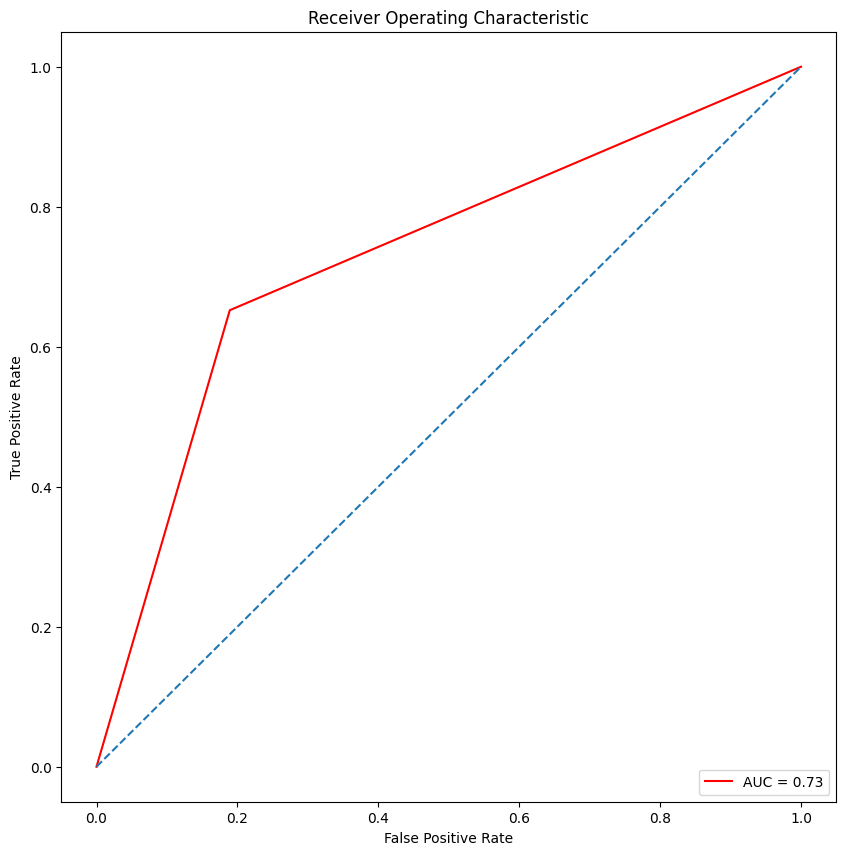

In [44]:
# Plot ROC curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred, average='weighted')
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % auc_roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')